# Filter public/charter school data into team-specific data sets

Author(s): Jaren Haber<br>
Project Manager: Jaren Haber, PhD Candidate <br>
Contact: jhaber@berkeley.edu

Institution: University of California, Berkeley <br>
Program: Undergraduate Research Apprentice Program (URAP) <br>

Date created: Nov. 27, 2018<br>
Last modified: Nov. 27, 2018

Description: Loads most recent charter data, filters to key variables, converts the DF for efficiency, reorders & renames variables, and saves data specifically for statistics and geospatial teams.

## Initialize

### Import packages & functions

In [1]:
import pandas as pd # For working with DataFrames
import ast # For working with strings
import numpy as np # For numerical things
import re # For cleaning webtext

In [2]:
# For displaying basic DF info, storing DFs for memory efficiency, and loading a filtered DF:
from df_tools import check_df, convert_df, load_filtered_df

# For quickly loading & saving pickle files in Python:
from quickpickle import quickpickle_dump, quickpickle_load 

# For saving and loading text lists to/from file:
from textlist_file import write_list, load_list 

# For calculating densities (already built; rest are coming soon!), school closure rates, and cleaned performance variables:
from df_calc import density_calc

### Define file paths

In [3]:
# Input files:
charters_path = "../../nowdata/charters_2015.pkl"
pubschools_path = "../../nowdata/pubschools_2015.pkl"

charters_small_loc = "../../nowdata/backups/charters_parsed_03-04_no-text_SMALL.csv"
ACSsmall_loc = "../data/ACS_2016_sd-merged_SMALL.csv"
ACSfull_loc = "../data/ACS_2016_sd-merged_FULL.csv"
SAIPE_loc = "../data/SAIPE_2016_sd.txt"

In [4]:
# Output files:
charters_storepath = "../../nowdata/backups/charters_full_2015_250_v2a.pkl"
pubschools_storepath = "../../nowdata/backups/pubschools_full_2015_CRDC.pkl"

geo_storepath = "../../nowdata/backups/charters_geo_2015_v2a.csv"
geoteam_path = "../../geospatial/data/charters_geo_2015_v2a.csv"

stats_storepath = "../../nowdata/backups/charters_stats_2015_v2a.csv"
stats_text_storepath = "../../nowdata/backups/charters_statstext_2015_v2a.pkl"

## Load & filter data

In [5]:
# ACS (school district) data
acs = pd.read_csv(ACSfull_loc, header = [0, 1], encoding="latin1", low_memory=False) # School district social data (ACS, 2012-16)
print(acs.shape)
list(acs)

(13406, 126)


[('FIPS', 'Geo_FIPS'),
 ('Name of Area', 'Geo_NAME'),
 ('Qualifying Name', 'Geo_QName'),
 ('State/U.S.-Abbreviation (USPS)', 'Geo_STUSAB'),
 ('Summary Level', 'Geo_SUMLEV'),
 ('File Identification', 'Geo_FILEID'),
 ('Logical Record Number', 'Geo_LOGRECNO'),
 ('State (FIPS)', 'Geo_STATE'),
 ('School District (Elementary)', 'Geo_SDELM'),
 ('School District (Secondary)', 'Geo_SDSEC'),
 ('School District (Unified)', 'Geo_SDUNI'),
 ('Geographic Identifier', 'Geo_GEOID'),
 ('Area (Land)', 'Geo_AREALAND'),
 ('Area (Water)', 'Geo_AREAWATR'),
 ('Total Population', 'SE_T002_001'),
 ('Population Density (Per Sq. Mile)', 'SE_T002_002'),
 ('Area (Land)', 'SE_T002_003'),
 ('% Total Population: Under 18 Years', 'PCT_SE_T009_002'),
 ('% Total Population: 18 to 34 Years', 'PCT_SE_T009_003'),
 ('% Total Population: 35 to 64 Years', 'PCT_SE_T009_004'),
 ('% Total Population: 65 and Over', 'PCT_SE_T009_005'),
 ('% Total Population: White Alone', 'PCT_SE_T013_002'),
 ('% Total Population: Black or African 

In [6]:
# Small charters data set (previously used for geospatial)
charters_smalldf = load_filtered_df(charters_small_loc, [])

# rows and cols:  (6972, 32)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
STATENAME
LEAID
LEA_NAME
NCESSCH
SCH_NAME
TOTFRL: 218 missing
AM: 218 missing
AS: 218 missing
BL: 218 missing
HI: 218 missing
HP: 218 missing
MEMBER: 218 missing
TR: 218 missing
TITLEI: 624 missing
FTE: 218 missing
YEAR_OPENED: 70 missing
YEAR_CLOSED: 6484 missing
LATCODE: 114 missing
LONGCODE: 114 missing
LOCALE: 114 missing
ALL_MTH00PCTPROF_1415: 688 missing
ALL_RLA00PCTPROF_1415: 688 missing
ADDRESS14
ess_count: 1596 missing
prog_count: 1596 missing
rit_count: 1596 missing
ess_strength: 2016 missing
prog_strength: 2014 missing
AGE: 70 missing
PCTETH: 259 missing
PLACE: 114 missing
TOTETH: 218 missing


In [7]:
# Load full public school data set - just the cols needed to count density
pubdf_small = load_filtered_df(pubschools_path, ["NCESSCH", "GEO_LEAID", "LEAID", "TRUE_CHARTER", "SY_STATUS15"])

# rows and cols:  (136825, 5)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
NCESSCH
GEO_LEAID: 34502 missing
LEAID: 36593 missing
TRUE_CHARTER
SY_STATUS15: 34699 missing


In [8]:
# Add to pub schools LEA_NAME from original data
pubadd = pd.read_csv("../../data_management/data/ccd_sch_029_1516_w_2a_011717.csv", usecols=["NCESSCH", "LEA_NAME"], encoding = "latin1", low_memory=False)
pubdf_small = pd.merge(pubdf_small, pubadd, how="left", on="NCESSCH")
check_df(pubdf_small, "NCESSCH")

# rows and cols:  (136825, 6)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
NCESSCH
GEO_LEAID: 34502 missing
LEAID: 36593 missing
TRUE_CHARTER
SY_STATUS15: 34699 missing
LEA_NAME: 34424 missing


In [9]:
# Define variables to keep from full charter data set
keepvars = ['LEVEL', 'MEMBER', 'SE_T002_002', 'AGE', 'PCTETH', 'WH', 'PCTFRL', 'PCTETH_SD', 'PCT_SE_T113_002', 
            'ESS_VALID_RATIO', 'PROG_VALID_RATIO', 'INQUIRY_RATIO', 'DISCIPLINE_RATIO', 'LSTATE', 'CMO_NAME', 
            'LEAID', 'GEO_LEAID', 'NCESSCH', 'SY_STATUS15', 'close_rate16', 'TITLEI', 'SCHNAM15',
            'LAT1516', 'LON1516', 'ADDRESS16', 'ALL_RLA00PCTPROF_1516', 'ALL_MTH00PCTPROF_1516']

expul_cols = ['TOT_DISCWODIS_EXPWE_M', 'TOT_DISCWODIS_EXPWE_F', 'TOT_DISCWODIS_EXPWOE_M', 
              'TOT_DISCWODIS_EXPWOE_F', 'TOT_DISCWDIS_EXPWE_IDEA_M', 'TOT_DISCWDIS_EXPWE_IDEA_F', 
              'TOT_DISCWDIS_EXPWOE_IDEA_M', 'TOT_DISCWDIS_EXPWOE_IDEA_F']

In [10]:
# Load and filter charter data set
charterdf = load_filtered_df(charters_path, keepvars+expul_cols)

# rows and cols:  (10965, 35)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
LEVEL: 3577 missing
MEMBER: 4034 missing
SE_T002_002: 7951 missing
AGE: 595 missing
PCTETH: 4058 missing
WH: 4034 missing
PCTFRL: 4037 missing
PCTETH_SD: 7892 missing
PCT_SE_T113_002: 7892 missing
ESS_VALID_RATIO: 4103 missing
PROG_VALID_RATIO: 4103 missing
INQUIRY_RATIO: 4103 missing
DISCIPLINE_RATIO: 4103 missing
LSTATE: 3577 missing
CMO_NAME: 8421 missing
LEAID: 4016 missing
GEO_LEAID: 3612 missing
NCESSCH
SY_STATUS15: 3619 missing
close_rate16
TITLEI: 4597 missing
SCHNAM15: 3619 missing
LAT1516: 3613 missing
LON1516: 3613 missing
ADDRESS16: 3532 missing
ALL_RLA00PCTPROF_1516: 4663 missing
ALL_MTH00PCTPROF_1516: 4665 missing
TOT_DISCWODIS_EXPWE_M: 5368 missing
TOT_DISCWODIS_EXPWE_F: 5368 missing
TOT_DISCWODIS_EXPWOE_M: 5368 missing
TOT_DISCWODIS_EXPWOE_F: 5368 missing
TOT_DISCWDIS_EXPWE_IDEA_M: 5368 missing
TOT_DISCWDIS_EXPWE_IDEA_F: 5368 missing
TOT_DISCWDIS_EXPWOE_IDEA_M: 5368 missing


In [11]:
# Add to charter data LEA_NAME and LOCALE15 from original data
lea_add = pd.read_csv("../../data_management/data/ccd_sch_029_1516_w_2a_011717.csv", usecols=["NCESSCH", "LEA_NAME"], encoding = "latin1", low_memory=False)
locale_add = pd.read_excel("../../data_management/data/EDGE_GEOCODE_PUBLICSCH_1516/EDGE_GEOCODE_PUBLICSCH_1516.xlsx", encoding = "latin1")
locale_add = locale_add[["NCESSCH", "LOCALE15"]] # Filter manually

charterdf = pd.merge(charterdf, lea_add, how="left", on="NCESSCH")
charterdf = pd.merge(charterdf, locale_add, how="left", on="NCESSCH")

In [12]:
# Add to charter schools child poverty estimates from original SAIPE 2016 data
saipe_add = pd.read_fwf(SAIPE_loc, names=["FIPST", "DISTID", "LEANAME", "POPTOT_S16", "POP517_S16", "CHILDPOVNUM_S16", "FILE_DATE"], 
                        colspecs = [(0,2), (3,8), (9,81), (82,90), (91,99), (100,108), (109,130)], 
                        dtype={"FIPST":str, "DISTID":str, "LEANAME":str, "POPTOT_S16":"uint32", "POP517_S16":"uint32", "CHILDPOV_S16":"uint32", "FILE_DATE":str}) # Load data

# To simplify merging process, create same id variable with same dtype for SAIPE as for charter data
mergevar = "GEO_LEAID"
saipe_add[mergevar] = (saipe_add["FIPST"] + saipe_add["DISTID"]).astype(float)
saipe_add["CHILDPOV_S16"] = saipe_add["CHILDPOVNUM_S16"]/saipe_add["POP517_S16"] # Divide # children (age 5-17) in poverty by total # children
saipe_add = saipe_add[[mergevar, "CHILDPOV_S16"]] # Reduce to key vars

charterdf = pd.merge(charterdf, saipe_add, how="left", on="GEO_LEAID") # Merge DFs

In [13]:
# Filter to only open schools
filtered_STATUS = (charterdf['SY_STATUS15'] == 1) | (charterdf['SY_STATUS15'] == 3) | (charterdf['SY_STATUS15'] == 4) | (charterdf['SY_STATUS15'] == 5) | (charterdf['SY_STATUS15'] == 8)
chopendf = charterdf.loc[filtered_STATUS]

check_df(chopendf, "NCESSCH")

# rows and cols:  (6947, 38)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
LEVEL
MEMBER: 19 missing
SE_T002_002: 4076 missing
AGE: 19 missing
PCTETH: 43 missing
WH: 19 missing
PCTFRL: 22 missing
PCTETH_SD: 4017 missing
PCT_SE_T113_002: 4017 missing
ESS_VALID_RATIO: 647 missing
PROG_VALID_RATIO: 647 missing
INQUIRY_RATIO: 647 missing
DISCIPLINE_RATIO: 647 missing
LSTATE
CMO_NAME: 4582 missing
LEAID: 3 missing
GEO_LEAID
NCESSCH
SY_STATUS15
close_rate16
TITLEI: 908 missing
SCHNAM15
LAT1516
LON1516
ADDRESS16: 33 missing
ALL_RLA00PCTPROF_1516: 649 missing
ALL_MTH00PCTPROF_1516: 651 missing
TOT_DISCWODIS_EXPWE_M: 1360 missing
TOT_DISCWODIS_EXPWE_F: 1360 missing
TOT_DISCWODIS_EXPWOE_M: 1360 missing
TOT_DISCWODIS_EXPWOE_F: 1360 missing
TOT_DISCWDIS_EXPWE_IDEA_M: 1360 missing
TOT_DISCWDIS_EXPWE_IDEA_F: 1360 missing
TOT_DISCWDIS_EXPWOE_IDEA_M: 1360 missing
TOT_DISCWDIS_EXPWOE_IDEA_F: 1360 missing
LEA_NAME
LOCALE15
CHILDPOV_S16: 136 missing


In [109]:
# Create new variable with density of charter schools
chopendf["PUBLIC_DENSITY"], chopendf["CHARTER_DENSITY"] = density_calc(chopendf, pubdf_small, "GEO_LEAID", "NCESSCH", "TRUE_CHARTER")

# Fill missing charter densities with zero, because otherwise districts with no charters show NaN
chopendf["CHARTER_DENSITY"] = chopendf["CHARTER_DENSITY"].fillna(0)

#charterdf[["PUBLIC_DENSITY", "CHARTER_DENSITY"]]
check_df(chopendf, "NCESSCH")

# rows and cols:  (6947, 40)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
LEVEL
MEMBER: 19 missing
SE_T002_002: 4076 missing
AGE: 19 missing
PCTETH: 43 missing
WH: 19 missing
PCTFRL: 22 missing
PCTETH_SD: 4017 missing
PCT_SE_T113_002: 4017 missing
ESS_VALID_RATIO: 647 missing
PROG_VALID_RATIO: 647 missing
INQUIRY_RATIO: 647 missing
DISCIPLINE_RATIO: 647 missing
LSTATE
CMO_NAME: 4582 missing
LEAID: 3 missing
GEO_LEAID
NCESSCH
SY_STATUS15
close_rate16
TITLEI: 908 missing
SCHNAM15
LAT1516
LON1516
ADDRESS16: 33 missing
ALL_RLA00PCTPROF_1516: 649 missing
ALL_MTH00PCTPROF_1516: 651 missing
TOT_DISCWODIS_EXPWE_M: 1360 missing
TOT_DISCWODIS_EXPWE_F: 1360 missing
TOT_DISCWODIS_EXPWOE_M: 1360 missing
TOT_DISCWODIS_EXPWOE_F: 1360 missing
TOT_DISCWDIS_EXPWE_IDEA_M: 1360 missing
TOT_DISCWDIS_EXPWE_IDEA_F: 1360 missing
TOT_DISCWDIS_EXPWOE_IDEA_M: 1360 missing
TOT_DISCWDIS_EXPWOE_IDEA_F: 1360 missing
LEA_NAME
LOCALE15
CHILDPOV_S16: 136 missing
PUBLIC_DENSITY
CHARTER_DENSITY


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [110]:
# Combine columns for expulsions
#chopendf["Total Number of Students who received an expulsion"] = chopendf[expul_cols].sum(axis=1)
chopendf["Total Number of Students who received an expulsion"] = \
chopendf["TOT_DISCWODIS_EXPWE_M"] + chopendf["TOT_DISCWODIS_EXPWE_F"] + \
chopendf["TOT_DISCWODIS_EXPWOE_M"] + chopendf["TOT_DISCWODIS_EXPWOE_F"] + chopendf["TOT_DISCWDIS_EXPWE_IDEA_M"] + \
chopendf["TOT_DISCWDIS_EXPWE_IDEA_F"] + chopendf["TOT_DISCWDIS_EXPWOE_IDEA_M"] + chopendf["TOT_DISCWDIS_EXPWOE_IDEA_F"]

# Drop the specific expulsion columns
chopendf.drop(columns=expul_cols, inplace=True, axis=1)

# Recode locale columns:
chopendf["PLACE"] = chopendf["LOCALE15"].replace(to_replace={"11":"City", "12":"City", "13":"City", "21":"Suburb", "22":"Suburb", "23":"Suburb", "31":"Town", "32":"Town", "33":"Town", "41":"Rural", "42":"Rural", "43":"Rural"}, value=None).astype('category')
chopendf["URBAN"] = chopendf["LOCALE15"].replace(to_replace={"11":1, "12":1, "13":1, "21":0, "22":0, "23":0, "31":0, "32":0, "33":0, "41":0, "42":0, "43":0}, value=None).astype('category')
chopendf["LOCALE15"] = chopendf["LOCALE15"].replace(to_replace={"11":"City (large)", "12":"City (midsize)", "13":"City (small)", "21":"Suburb (large)", "22":"Suburb (midsize)", "23":"Suburb (small)", "31":"Town (fringe)", "32":"Town (distant)", "33":"Town (remote)", "41":"Rural (fringe)", "42":"Rural (distant)", "43":"Rural (remote)"}, value=None).astype('category')
#chopendf["TITLEI"] = chopendf["TITLEI"].map({"Yes":1.0, "No":0.0}).astype('category') # already done

# Clean up (grade-) LEVEL column and create dummies:
chopendf['LEVEL'].replace(to_replace="N", value=np.NaN, inplace=True) # Replace "N" with "NaN"
chopendf['PRIMARY'] = chopendf['LEVEL'].replace(to_replace=["1", "2", "3", "4"], value=[1, 0, 0, 0]).fillna(0).astype('category') # Binary indicating whether school is primary
chopendf['MIDDLE'] = chopendf['LEVEL'].replace(to_replace=["1", "2", "3", "4"], value=[0, 1, 0, 0]).fillna(0).astype('category') # Binary indicating whether school is primary
chopendf['HIGH'] = chopendf['LEVEL'].replace(to_replace=["1", "2", "3", "4"], value=[0, 0, 1, 0]).fillna(0).astype('category') # Binary indicating whether school is primary
chopendf['OTHER_LEVEL'] = chopendf['LEVEL'].replace(to_replace=["1", "2", "3", "4"], value=[0, 0, 0, 1]).fillna(0).astype('category') # Binary indicating whether school is primary
chopendf['LEVEL'].replace(to_replace=["1", "2", "3", "4"], value=["Primary", "Middle", "High", "Other"], inplace=True) # Recode for clarity

chopendf["IN_CMO"] = charterdf["CMO_NAME"].notnull().replace([True, False], [1, 0]).fillna(0).astype('category') # Define to 1 if in CMO
chopendf["PCTWHT"] = (chopendf["WH"]/chopendf["MEMBER"]).apply(pd.to_numeric, downcast='float')  # Percent white K-12 students

# Create new binary columns for ethnic isolation, i.e. percentage of racial minorities > some threshold 
# (using various thresholds)
chopendf["ETHNIC_ISOLATED99"] = np.where(chopendf["PCTETH"]>=0.99, 1, 0) # Whether school is ethnically isolated (>99% nonwhite) 
chopendf["ETHNIC_ISOLATED95"] = np.where(chopendf["PCTETH"]>=0.95, 1, 0) # >95% nonwhite
chopendf["ETHNIC_ISOLATED90"] = np.where(chopendf["PCTETH"]>=0.90, 1, 0) # >90% nonwhite
chopendf["ETHNIC_ISOLATED80"] = np.where(chopendf["PCTETH"]>=0.80, 1, 0) # >80% nonwhite
chopendf["ETHNIC_ISOLATED70"] = np.where(chopendf["PCTETH"]>=0.70, 1, 0) # >70% nonwhite
chopendf["WHITE_ISOLATED99"] = np.where(chopendf["PCTWHT"]>=0.99, 1, 0) # Whether school is predominantly white (>99%) 
chopendf["WHITE_ISOLATED95"] = np.where(chopendf["PCTWHT"]>=0.95, 1, 0) # >95% white
chopendf["WHITE_ISOLATED90"] = np.where(chopendf["PCTWHT"]>=0.90, 1, 0) # >90% white
chopendf["WHITE_ISOLATED80"] = np.where(chopendf["PCTWHT"]>=0.80, 1, 0) # >80% white
chopendf["WHITE_ISOLATED70"] = np.where(chopendf["PCTWHT"]>=0.70, 1, 0) # >70% white

chopendf = convert_df(chopendf, []) # Make memory-efficient
check_df(chopendf, "NCESSCH") # Check missing vars

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

# rows and cols:  (6947, 51)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
LEVEL: 19 missing
MEMBER: 19 missing
SE_T002_002: 4076 missing
AGE: 19 missing
PCTETH: 43 missing
WH: 19 missing
PCTFRL: 22 missing
PCTETH_SD: 4017 missing
PCT_SE_T113_002: 4017 missing
ESS_VALID_RATIO: 647 missing
PROG_VALID_RATIO: 647 missing
INQUIRY_RATIO: 647 missing
DISCIPLINE_RATIO: 647 missing
LSTATE
CMO_NAME: 4582 missing
LEAID: 3 missing
GEO_LEAID
NCESSCH
SY_STATUS15
close_rate16
TITLEI: 908 missing
SCHNAM15
LAT1516
LON1516
ADDRESS16: 33 missing
ALL_RLA00PCTPROF_1516: 649 missing
ALL_MTH00PCTPROF_1516: 651 missing
LEA_NAME
LOCALE15
CHILDPOV_S16: 136 missing
PUBLIC_DENSITY
CHARTER_DENSITY
Total Number of Students who received an expulsion: 1360 missing
PLACE
URBAN
PRIMARY
MIDDLE
HIGH
OTHER_LEVEL
IN_CMO
PCTWHT: 43 missing
ETHNIC_ISOLATED99
ETHNIC_ISOLATED95
ETHNIC_ISOLATED90
ETHNIC_ISOLATED80
ETHNIC_ISOLATED70
WHITE_ISOLATED99
WHITE_ISOLATED95
WHITE_ISOLATED90
WHITE_ISOLATED80
WHITE_I

## Merge ACS data again using new GEO_LEAID

In [111]:
acs = pd.read_csv(ACSfull_loc, header = [0, 1], encoding="latin1", low_memory=False) # School district social data (ACS, 2012-16)

acs_tups = [('FIPS', 'Geo_FIPS'), 
            ('% Total Population: White Alone', 'PCT_SE_T013_002'), 
            ('% Families: Income in Below Poverty Level', 'PCT_SE_T113_002'), 
            ('Population Density (Per Sq. Mile)', 'SE_T002_002'), 
            ("% Population 25 Years and Over: Bachelor's Degree", 'PCT_SE_T025_005'), 
            ("% Population 25 Years and Over: Master's Degree", 'PCT_SE_T025_006'), 
            ('% Population 25 Years and Over: Professional School Degree', 'PCT_SE_T025_007'), 
            ('% Population 25 Years and Over: Doctorate Degree', 'PCT_SE_T025_008'), 
            ('% Civilian Population in Labor Force 16 Years and Over: Unemployed', 'PCT_SE_T037_003'), 
            ('% Total Population: Foreign Born', 'PCT_SE_T133_003')]

# Keep only ACS cols we need
acs = acs[acs_tups]

# Get list of ACS vars to drop from school dfs (to avoid risk of duplication):
acsvars_ch, acsvars_pub = [], []
for var in list(acs):
    if var[1] in list(chopendf) and var[1] not in acsvars_ch:
        acsvars_ch.append(var[1])
    #if var[1] in list(pubsdf) and var[1] not in acsvars_pub:
    #    acsvars_pub.append(var[1])
    #if var in list(pubsdf) and var not in acsvars_pub:
    #    acsvars_pub.append(var)

mergevar = "GEO_LEAID"
acs[mergevar] = acs[("FIPS", "Geo_FIPS")] # Simplifies merging process
chopendf = chopendf.drop(acsvars_ch, axis=1) # Drop ACS vars
chopendf = pd.merge(chopendf, acs, how="left", on=mergevar) # Merge

# Rename ACS vars so they're single index--and thus easier to work with
rename_dict = dict(((x,y),y) for x,y in acs_tups)
chopendf.rename(index=str, columns=rename_dict, inplace=True) # Rename columns using renaming dict

# Create new ACS variables
chopendf["PCTBA_SD"] = chopendf["PCT_SE_T025_005"] + chopendf["PCT_SE_T025_006"] + chopendf['PCT_SE_T025_007'] + chopendf['PCT_SE_T025_008'] # "% Population 25 Years and Over: Bachelor's Degree or Higher" (school district)
chopendf['PCTETH_SD'] = 1 - chopendf['PCT_SE_T013_002'] # "% Total Population: Nonwhite" (school district)

/opt/conda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [112]:
# Clean up by dropping vars not needed for analysis
chopendf.drop(columns=["WH", "PCTWHT", "SY_STATUS15", "LEAID", "PCT_SE_T013_002", "PCT_SE_T025_005", "PCT_SE_T025_006", "PCT_SE_T025_007", "PCT_SE_T025_008"], 
              axis=1, inplace=True)

# Rename variables
chopendf = chopendf.rename(
    index=str, columns={'LEVEL':'level', 
                        'PRIMARY':'primary', 
                        'MIDDLE':'middle', 
                        'HIGH':'high', 
                        'OTHER_LEVEL':'otherlevel', 
                        'MEMBER':'students', 
                        'SE_T002_002':'popdensity', 
                        'PCT_SE_T037_003':'unemployment', 
                        'PCT_SE_T133_003':'foreignborn',
                        'CHILDPOV_S16':'childpovertysd', 
                        'AGE':'age', 
                        'PCTETH':'pocschool', 
                        'ETHNIC_ISOLATED99':'ethnicisolated99', 
                        'ETHNIC_ISOLATED95':'ethnicisolated95', 
                        'ETHNIC_ISOLATED90':'ethnicisolated90', 
                        'ETHNIC_ISOLATED80':'ethnicisolated80', 
                        'ETHNIC_ISOLATED70':'ethnicisolated70', 
                        'WHITE_ISOLATED99':'whiteisolated99', 
                        'WHITE_ISOLATED95':'whiteisolated95', 
                        'WHITE_ISOLATED90':'whiteisolated90', 
                        'WHITE_ISOLATED80':'whiteisolated80', 
                        'WHITE_ISOLATED70':'whiteisolated70', 
                        'PCTFRL':'povertyschool', 
                        'PCTETH_SD':'pocsd', 
                        'PCT_SE_T113_002':'povertysd', 
                        'ESS_VALID_RATIO':'traditional', 
                        'PROG_VALID_RATIO':'progressive', 
                        'INQUIRY_RATIO':'inquiry', 
                        'DISCIPLINE_RATIO':'discipline', 
                        'Total Number of Students who received an expulsion':'expulsions', 
                        'LSTATE':'state', 
                        'CMO_NAME':'cmoname', 
                        'IN_CMO':'cmo', 
                        'GEO_LEAID':'geodistrict', 
                        'SCHNAM15':'schoolname', 
                        'LEA_NAME':'districtname', 
                        'PCTBA_SD':'collegesd', 
                        'close_rate16':'closerate', 
                        'ADDRESS16':'address', 
                        'LAT1516':'latitude', 
                        'LON1516':'longitude', 
                        'LOCALE15':'localefine', 
                        'PLACE':'locale', 
                        'URBAN':'urban',
                        'TITLEI':'titlei', 
                        'ALL_RLA00PCTPROF_1516':'readingscore', 
                        'ALL_MTH00PCTPROF_1516':'mathscore', 
                        'PUBLIC_DENSITY':'publicdensity', 
                        'CHARTER_DENSITY':'charterdensity'})

check_df(chopendf, "NCESSCH") # Check missing vars

# rows and cols:  (6947, 51)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
level: 19 missing
students: 19 missing
age: 19 missing
pocschool: 43 missing
povertyschool: 22 missing
pocsd: 31 missing
traditional: 647 missing
progressive: 647 missing
inquiry: 647 missing
discipline: 647 missing
state
cmoname: 4582 missing
geodistrict
NCESSCH
closerate
titlei: 908 missing
schoolname
latitude
longitude
address: 33 missing
readingscore: 649 missing
mathscore: 651 missing
districtname
localefine
childpovertysd: 136 missing
publicdensity
charterdensity
expulsions: 1360 missing
locale
urban
primary
middle
high
otherlevel
cmo
ethnicisolated99
ethnicisolated95
ethnicisolated90
ethnicisolated80
ethnicisolated70
whiteisolated99
whiteisolated95
whiteisolated90
whiteisolated80
whiteisolated70
Geo_FIPS: 31 missing
povertysd: 31 missing
popdensity: 49 missing
unemployment: 31 missing
foreignborn: 31 missing
collegesd: 31 missing


## Create, clean, & reorder data

### Data for statistics team (and sharing)

In [113]:
# Retain and reorder variables for stats team
statsdf = chopendf[['inquiry', 'discipline', 'traditional', 'progressive', 
                    'readingscore', 'mathscore', 
                    'pocschool', 'pocsd', 'povertyschool', 'povertysd', 'childpovertysd', 
                    'students', 'age', 'state', 'cmo', 'cmoname',  
                    'expulsions', 'titlei', 'geodistrict', 'NCESSCH', 
                    'urban', 'primary', 'middle', 'high', 'otherlevel', 
                    'ethnicisolated99', 'ethnicisolated95', 'ethnicisolated90', 'ethnicisolated80', 'ethnicisolated70', 
                    'whiteisolated99', 'whiteisolated95', 'whiteisolated90', 'whiteisolated80', 'whiteisolated70', 
                    'collegesd', 'popdensity', 'unemployment', 'foreignborn', 
                    'closerate', 'publicdensity', 'charterdensity']]

# Clean up by dropping schools missing core variables
statsdf = statsdf[statsdf["students"].notnull()]
statsdf = statsdf[statsdf["povertyschool"].notnull()]
statsdf = statsdf[statsdf["povertysd"].notnull()]
statsdf = statsdf[statsdf["pocschool"].notnull()]
statsdf = statsdf[statsdf["pocsd"].notnull()]
statsdf = statsdf[statsdf["age"].notnull()]
statsdf = statsdf[statsdf["inquiry"].notnull()]
statsdf = statsdf[statsdf["discipline"].notnull()]

check_df(statsdf, "NCESSCH") # Check missing vars again

# rows and cols:  (6238, 42)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
inquiry
discipline
traditional
progressive
readingscore: 566 missing
mathscore: 568 missing
pocschool
pocsd
povertyschool
povertysd
childpovertysd: 3 missing
students
age
state
cmo
cmoname: 3986 missing
expulsions: 1079 missing
titlei: 801 missing
geodistrict
NCESSCH
urban
primary
middle
high
otherlevel
ethnicisolated99
ethnicisolated95
ethnicisolated90
ethnicisolated80
ethnicisolated70
whiteisolated99
whiteisolated95
whiteisolated90
whiteisolated80
whiteisolated70
collegesd
popdensity: 16 missing
unemployment
foreignborn
closerate
publicdensity
charterdensity


In [114]:
# Clean up performance variables
#statsdf["mathscore"] = statsdf["mathscore"]
#statsdf["readingscore"] = statsdf["readingscore"]

In [115]:
# Special application: Merge stats data with text
charter_textdf = load_filtered_df(charters_path, ["WEBTEXT", "NCESSCH"]) # Load and filter charter data set to only webtext
stats_textdf = pd.merge(statsdf, charter_textdf, how="left", on="NCESSCH") # Merge WEBTEXT into statsdf
stats_textdf.rename(index=str, inplace=True, columns={'WEBTEXT':'webtext'}) # Rename WEBTEXT to webtext (for consistency)
print()
check_df(stats_textdf, "NCESSCH")

# Merging all done, now we can drop unique identifier (NCESSCH) not needed for analysis
statsdf.drop(columns=["NCESSCH"], axis=1, inplace=True)
stats_textdf.drop(columns=["NCESSCH"], axis=1, inplace=True)

# rows and cols:  (10965, 2)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
NCESSCH
WEBTEXT

# rows and cols:  (6238, 43)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
inquiry
discipline
traditional
progressive
readingscore: 566 missing
mathscore: 568 missing
pocschool
pocsd
povertyschool
povertysd
childpovertysd: 3 missing
students
age
state
cmo
cmoname: 3986 missing
expulsions: 1079 missing
titlei: 801 missing
geodistrict
NCESSCH
urban
primary
middle
high
otherlevel
ethnicisolated99
ethnicisolated95
ethnicisolated90
ethnicisolated80
ethnicisolated70
whiteisolated99
whiteisolated95
whiteisolated90
whiteisolated80
whiteisolated70
collegesd
popdensity: 16 missing
unemployment
foreignborn
closerate
publicdensity
charterdensity
webtext


### Data for geospatial team

In [116]:
# Retain and reorder variables for geospatial team
geodf = chopendf[['inquiry', 'discipline', 'traditional', 'progressive', 
                  'readingscore', 'mathscore', 
                  'pocschool', 'pocsd', 'povertyschool', 'povertysd', 'childpovertysd', 
                  'students', 'age', 'state', 'cmoname', 'level', 'localefine', 
                  'expulsions', 'titlei', 'geodistrict', 'districtname', 'schoolname', 'NCESSCH', 
                  'ethnicisolated99', 'ethnicisolated70', 'whiteisolated99', 'whiteisolated70', 
                  'collegesd', 'popdensity', 'unemployment', 'foreignborn', 
                  'closerate', 'publicdensity', 'charterdensity', 
                  'address', 'latitude', 'longitude']]

# Clean up by dropping schools missing core variables
geodf = geodf[geodf["students"].notnull()]
geodf = geodf[geodf["povertyschool"].notnull()]
geodf = geodf[geodf["povertysd"].notnull()]
geodf = geodf[geodf["pocschool"].notnull()]
geodf = geodf[geodf["pocsd"].notnull()]
geodf = geodf[geodf["age"].notnull()]

check_df(geodf, "NCESSCH") # Check missing vars again

# Merging all done, now we can drop unique identifier (NCESSCH) not needed for analysis
geodf.drop(columns=["NCESSCH"], axis=1, inplace=True)

# rows and cols:  (6857, 37)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
inquiry: 619 missing
discipline: 619 missing
traditional: 619 missing
progressive: 619 missing
readingscore: 625 missing
mathscore: 628 missing
pocschool
pocsd
povertyschool
povertysd
childpovertysd: 105 missing
students
age
state
cmoname: 4521 missing
level
localefine
expulsions: 1323 missing
titlei: 872 missing
geodistrict
districtname
schoolname
NCESSCH
ethnicisolated99
ethnicisolated70
whiteisolated99
whiteisolated70
collegesd
popdensity: 17 missing
unemployment
foreignborn
closerate
publicdensity
charterdensity
address: 31 missing
latitude
longitude


## Save data to file

In [117]:
# Save data for stats team (and sharing)
statsdf.to_csv(stats_storepath, index=False)
quickpickle_dump(stats_textdf, stats_text_storepath)

# Save data for geospatial team
geodf.to_csv(geo_storepath, index=False)
geodf.to_csv(geoteam_path, index=False)

## Show correlations

In [118]:
!pip install openpyxl
import openpyxl

# FOR VISUALIZATIONS
import matplotlib, seaborn as sns
import matplotlib.pyplot as plt

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('ggplot')

sns.set_style("whitegrid")
sns.despine()

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<Figure size 432x288 with 0 Axes>

In [119]:
corrdf = statsdf[['inquiry', 'discipline', 'traditional', 'progressive', 
                    'readingscore', 'mathscore', 
                    'pocschool', 'pocsd', 'povertyschool', 'povertysd', 'childpovertysd', 
                    'students', 'expulsions', 
                    'collegesd', 'unemployment', 'popdensity', 
                    'publicdensity']]

In [120]:
corr = corrdf.corr(method='pearson')
cmap = sns.diverging_palette(5, 250, as_cmap=True)
corr = corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)

corr

,inquiry,discipline,traditional,progressive,pocschool,pocsd,povertyschool,povertysd,childpovertysd,students,expulsions,collegesd,unemployment,popdensity,publicdensity
inquiry,1,0.034,0.23,0.34,-0.013,-0.05,0.00024,-0.047,-0.053,-0.053,-0.032,0.047,-0.015,-0.035,0.0043
discipline,0.034,1,0.096,-0.026,0.0036,0.02,0.012,0.027,0.025,0.021,0.005,-0.032,0.046,-0.022,-0.014
traditional,0.23,0.096,1,0.08,-0.0061,-0.019,-0.00062,0.0029,0.0055,-0.049,-0.025,-0.021,0.0086,-0.019,-0.0042
progressive,0.34,-0.026,0.08,1,0.0011,-0.011,0.0062,0.0028,0.004,-0.045,-0.021,0.019,-0.011,0.0011,-0.0081
pocschool,-0.013,0.0036,-0.0061,0.0011,1,0.064,0.63,0.061,0.055,0.0086,-0.0015,-0.026,0.039,0.037,-0.0017
pocsd,-0.05,0.02,-0.019,-0.011,0.064,1,0.041,0.55,0.57,0.08,0.03,-0.021,0.55,0.5,0.046
povertyschool,0.00024,0.012,-0.00062,0.0062,0.63,0.041,1,0.1,0.093,0.0026,-0.005,-0.099,0.072,-0.047,-0.012
povertysd,-0.047,0.027,0.0029,0.0028,0.061,0.55,0.1,1,0.94,0.0078,0.039,-0.51,0.73,0.25,-0.032
childpovertysd,-0.053,0.025,0.0055,0.004,0.055,0.57,0.093,0.94,1,0.0052,0.036,-0.47,0.71,0.26,-0.028
students,-0.053,0.021,-0.049,-0.045,0.0086,0.08,0.0026,0.0078,0.0052,1,0.17,0.023,0.016,0.05,0.046


In [121]:
corr.to_excel("../../Charter-school-identities/data/corrshade_112918.xlsx")

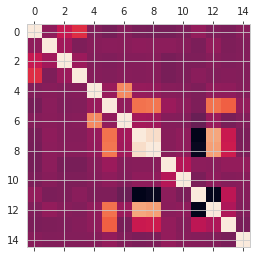

In [122]:
corr = corrdf.corr(method='pearson')
plt.matshow(corrdf.corr(method='pearson'))

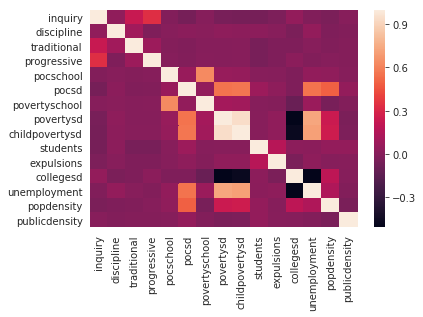

In [123]:
corr = corrdf.corr(method='pearson')
heatcorr = sns.heatmap(corr, 
                       xticklabels=corr.columns.values,
                       yticklabels=corr.columns.values)

heatcorr

In [124]:
fig = heatcorr.get_figure()
fig.savefig("../../Charter-school-identities/data/heatcorr_112918.png")